In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
from scipy.optimize import brentq
from matplotlib.ticker import FixedFormatter
from functions import quantizer, amplitude_sampler

import filters_func 

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def test_func(x):
    f0 = 1.2 # Hz
    return 0.3 * np.sin(2 * np.pi * f0 * x) + 0.5 * np.sin(2 * np.pi * 2 * f0 * x) 

In [8]:
'''
def test_func(x):
    f0 = 2.5 # Hz
    return 0.3 * signal.sawtooth(2 * np.pi * f0 * x, 0.6)
'''

'\ndef test_func(x):\n    f0 = 2.5 # Hz\n    return 0.3 * signal.sawtooth(2 * np.pi * f0 * x, 0.6)\n'

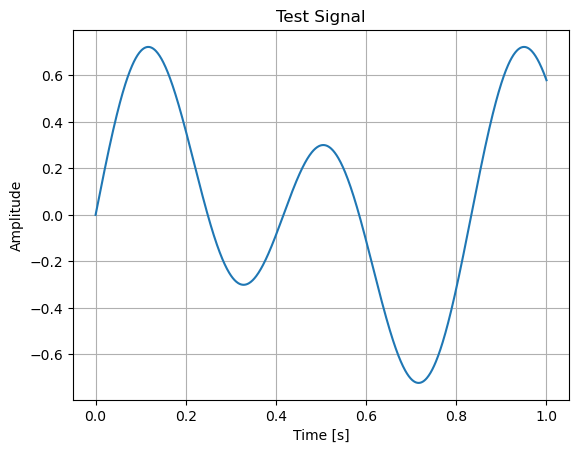

In [9]:
stop_time = 1
x= np.linspace(0, stop_time, 1000) #time vector 

plt.plot(x, test_func(x))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Test Signal')
plt.grid()

-0.3333333333333333


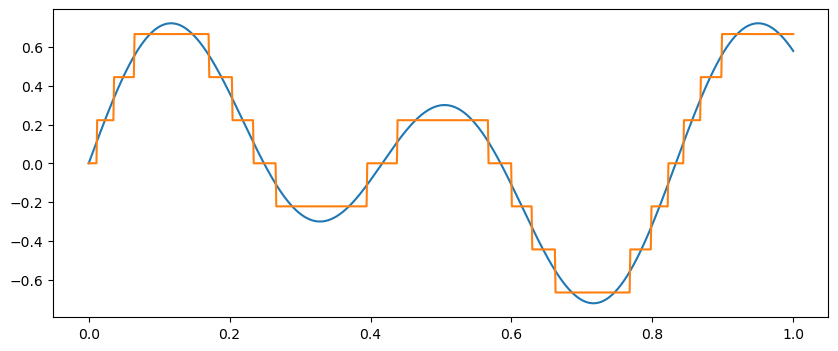

In [10]:
from functions import quantizer

q = quantizer(9)
step = q.step
print(q.qthreshold(2,3))

plt.rcParams["figure.figsize"] = (10,4)
plt.plot(x, test_func(x))
plt.plot(x, q.quantize(test_func(x)));



Transition instants: [0.         0.01138197 0.03537639 0.06484626 0.17091105 0.20388667
 0.2332678  0.26620047 0.39511597 0.43821736 0.56713287 0.60006553
 0.62944666 0.66242228 0.76848708 0.79795694 0.82195136 0.8447153
 0.86870973 0.89817959]
Bins index: [4 5 6 7 6 5 4 3 4 5 4 3 2 1 2 3 4 5 6 7]
Quantization values: [ 0.          0.22222222  0.44444444  0.66666667  0.44444444  0.22222222
  0.         -0.22222222  0.          0.22222222  0.         -0.22222222
 -0.44444444 -0.66666667 -0.44444444 -0.22222222  0.          0.22222222
  0.44444444  0.66666667]


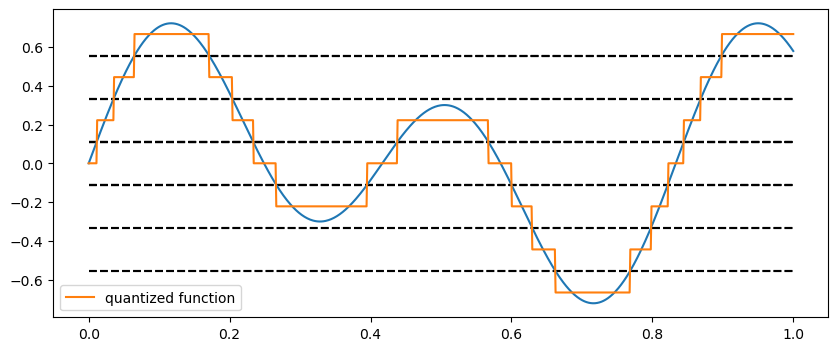

In [11]:
T = int(stop_time)

# transitions and bins
t, q_idx = amplitude_sampler(test_func, T, q)

# bins to quantization values
a = q.qvalue(q_idx)  #--> find the step y value for each bin 

print('Transition instants: {}'.format(t))
print('Bins index: {}'.format(q_idx))
print('Quantization values: {}'.format(a))

for i in range(0,len(q_idx)-1): 
    plt.hlines(q.qthreshold(q_idx[i],q_idx[i+1]), 0, 1,'black', linestyles='dashed', label='')

plt.plot(x, test_func(x));
plt.plot(x, q.quantize(test_func(x)), label='quantized function')
plt.legend()

In [12]:
Nqbits = 3; 

binary_idx = np.zeros(len(q_idx))
binary_list = []

def binary_encoding(bin_idx, Nqbits):
    for i in range(0,len(binary_idx)):
        # Convert to binary string, removing the '0b' prefix
        # Fill with zeros to have a fixed length of Nqbits

        binary_str = bin(bin_idx[i])[2:].zfill(Nqbits) 
        binary_list.append(binary_str)

def bit_extract(bi_list, idx):
    return  [bits[idx] for bits in bi_list]



binary_encoding(q_idx, Nqbits)

print('Bins index: {}'.format(q_idx))
print('Binary encoding: {}'.format(binary_list))
print('Least significant bit: {}'.format(bit_extract(binary_list, -1)))
print('Most significant bit (for 3 qbits): {}'.format(bit_extract(binary_list, 0)))
print('Middle bit (for 3 qbits): {}'.format(bit_extract(binary_list, 1)))


Bins index: [4 5 6 7 6 5 4 3 4 5 4 3 2 1 2 3 4 5 6 7]
Binary encoding: ['100', '101', '110', '111', '110', '101', '100', '011', '100', '101', '100', '011', '010', '001', '010', '011', '100', '101', '110', '111']
Least significant bit: ['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1']
Most significant bit (for 3 qbits): ['1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '1']
Middle bit (for 3 qbits): ['0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '1']


In [13]:
msb = [int(b) for b in bit_extract(binary_list, 0)]
lsb = [int(b) for b in bit_extract(binary_list, -1)]
middle = [int(b) for b in bit_extract(binary_list, 1)]

In [14]:
t_round = np.round(t, 3)
t_round = np.append(t_round, 1)
t_range = np.arange(0, 1 + 0.001, 0.001, dtype=float)

lsb_plot = np.zeros(len(t_range))
msb_plot = np.zeros(len(t_range))
middle_plot = np.zeros(len(t_range))


for i in range(len(lsb)):
    if lsb[i] == 1:
        lsb_plot[int(t_round[i]*1000) : int(t_round[i+1]*1000)] = 1
    if msb[i] == 1: 
        msb_plot[int(t_round[i]*1000) : int(t_round[i+1]*1000)] = 1
    if middle[i] == 1: 
        middle_plot[int(t_round[i]*1000) : int(t_round[i+1]*1000)] = 1


In [15]:
bit_waves = np.vstack([msb_plot,  middle_plot, lsb_plot])

Text(0.5, 1.0, 'Binary encoding of the quantized signal')

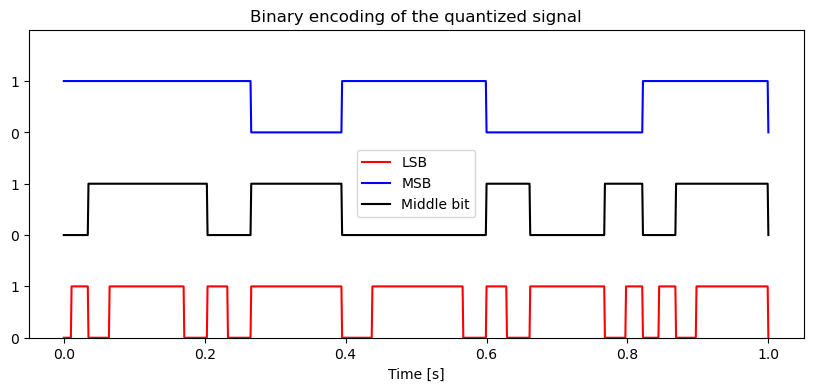

In [16]:
plt.plot(t_range, lsb_plot, 'red', label='LSB')
plt.plot(t_range, msb_plot+4, 'b', label='MSB')
plt.plot(t_range, middle_plot+2, 'black', label='Middle bit')
y_tick_labels = ['0', '1', '0', '1', '0', '1']
plt.yticks([0,1,2,3,4,5], y_tick_labels)
plt.legend()
plt.xlabel('Time [s]')
plt.ylim(0,6)
plt.title('Binary encoding of the quantized signal')



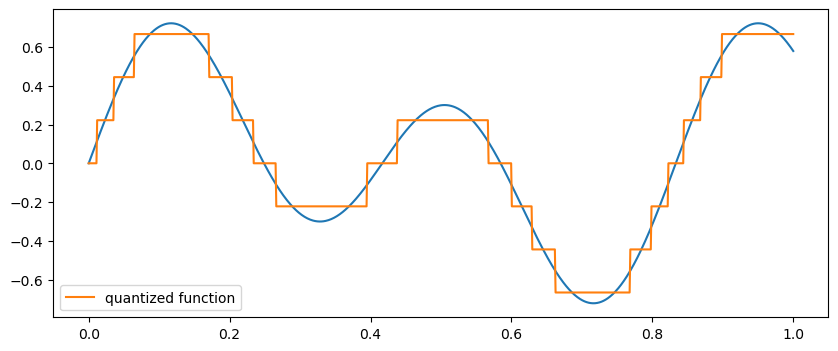

In [17]:
plt.plot(x, test_func(x));
plt.plot(x, q.quantize(test_func(x)), label='quantized function')
plt.legend()

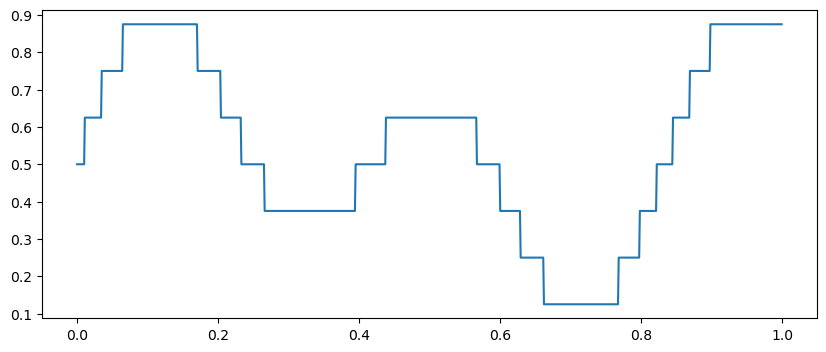

In [18]:
q_tot = 0
for i in range(1,np.shape(bit_waves)[0]+1):

    q_temp = 2**(-i)*bit_waves[i-1,:]
    q_tot = q_tot + q_temp

plt.plot(t_range[:-1], q_tot[:-1])

onda triangolare + skew rate 

## FIR filter design 

In [19]:
import filters_func 
from filters_func import perform  
 

In [20]:
filter_list = ['Moving average','Moving average_weight', 'Hamming window', 'Bartlet triangular', 'Butterworth', 'Low-pass']

### Moving average 
- the tap weights are all equal to 1/N
- each output sample is the average of the previous N input samples

In [42]:
from filters_func import FIR_class
f = FIR_class(K, delay)

# set filter taps and delay
K = 10
delay = 10
q_test = q.quantize(test_func(x))

MSE - Moving average filter =  0.06661894874681128
SNR - Moving average filter =  4.663889884572351


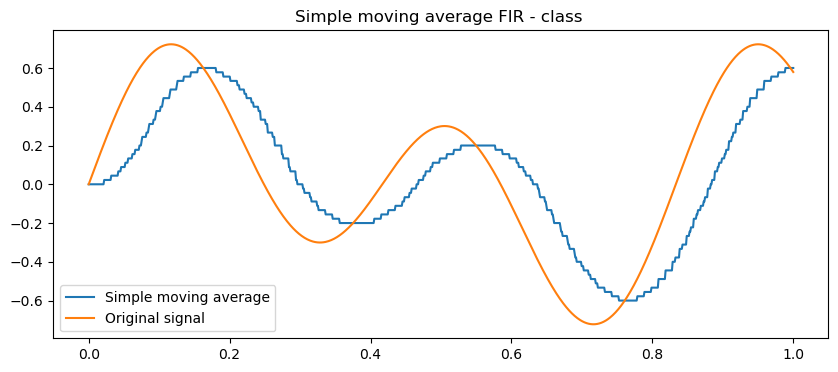

In [49]:
y_ma_class= f.movingAvg(x, q_test, corr=1)

plt.plot(x, y_ma_class, label='Simple moving average')
plt.plot(x, test_func(x),  label='Original signal')
#plt.plot(x[:-1], y_wma, label='Weighted moving average')
plt.title('Simple moving average FIR - class ')
plt.legend()

perform(y_ma_class, test_func(x), filter_list[0])

### Hamming window filter


MSE - Hamming window filter =  0.06060215135740426
SNR - Hamming window filter =  5.074987219011508


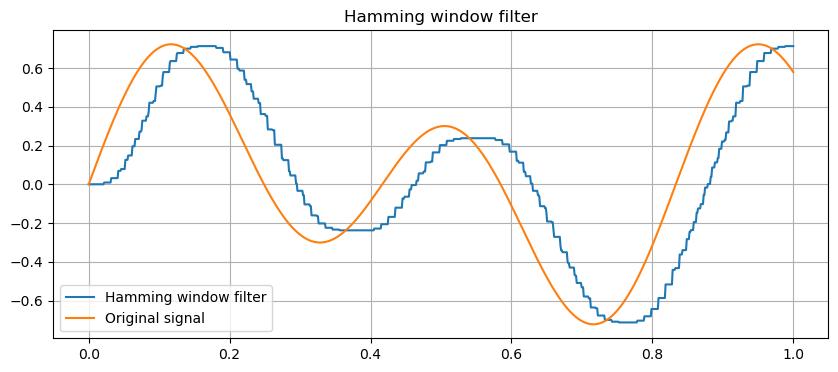

In [50]:
y_ham_class = f.hamming(x,q_test, corr = 0.22)

plt.plot(x, y_ham_class, label = 'Hamming window filter')
plt.plot(x, test_func(x),  label='Original signal')
plt.title("Hamming window filter")
plt.legend()
plt.grid()

perform(y_ham_class, test_func(x), filter_list[2])

### Bartlet triangular filter

In [51]:
y_bart_class = f.bartlet(x, q_test, corr=0.25)

MSE - Bartlet triangular filter =  0.05443832234188151
SNR - Bartlet triangular filter =  5.537686436666821


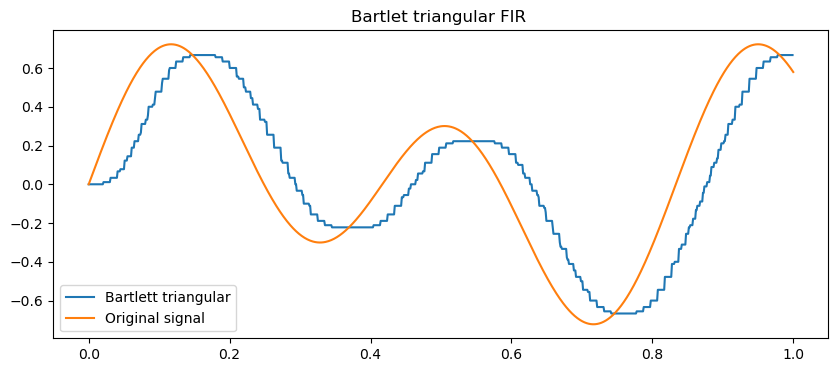

In [53]:
plt.plot(x[:-1], y_bart_class, label='Bartlett triangular')
plt.plot(x, test_func(x),  label='Original signal')
plt.title('Bartlet triangular FIR ')
plt.legend()

perform(y_bart_class, test_func(x)[:-1], filter_list[3])

### Butterworth filter

In [62]:
from filters_func import butter_lowpass_filter, low_pass_fir

In [59]:
fs_b = 500.0
T_b = 1/fs_b       # sample rate, Hz
cutoff = 2.5    # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs_b  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T_b * fs_b) # total number of samples

3
3


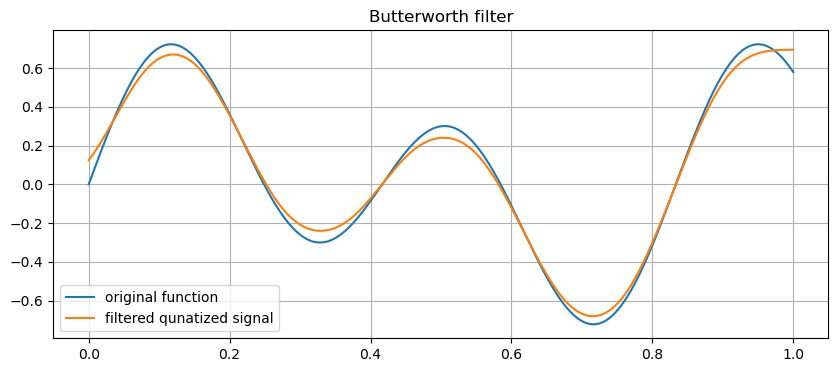

MSE - Butterworth filter =  0.0014751483884560997
SNR - Butterworth filter =  21.211510545001673


In [61]:
y = butter_lowpass_filter(q_test, cutoff, fs_b, order, nyq)

plt.plot(x, test_func(x), label='original function')
plt.plot(x, y, label='filtered qunatized signal')
plt.title('Butterworth filter')
plt.legend()
plt.grid()
plt.show()
perform(y, test_func(x), filter_list[4])

### Simple low-pass

MSE - Low-pass filter =  0.003407836916563876
SNR - Low-pass filter =  17.57507960408233


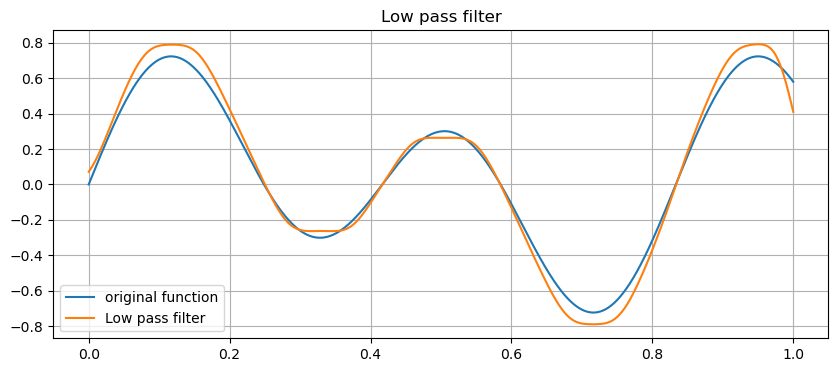

In [63]:
y_lp = low_pass_fir(q_test, cutoff, 130, fs_b)

plt.plot(x, test_func(x), label='original function')
plt.plot(x, y_lp, label='Low pass filter')
plt.title('Low pass filter')
plt.legend()
plt.grid()

perform(y_lp, test_func(x), filter_list[5])